# EMPCA vs Linear AE: Whitened Proof + No-Prewhiten Weighted Proof

This notebook provides two rigorous equivalence sections:

1. **Whitened complex space**: EMPCA vs exact complex tied linear AE.
2. **No-prewhiten native space**: PSD-weighted tied linear AE with **metric-aware normalization** (\(W^H D_w W = I\)) and comparison to native weighted EMPCA.

Both sections use the same dataset split and PSD model.


## Scope and assumptions

- Linear model only (no nonlinear AE).
- Gaussian noise model represented by PSD-derived diagonal frequency weights.
- Equivalence is up to subspace gauge (phase/sign/rotation).
- We evaluate using principal angles and weighted residual metrics.


In [29]:
import sys
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

sys.path.append("../../")
from reusable.empca_equivalence_utils import (
    baseline_correct,
    build_of_one_sided_weights,
    fit_empca_no_smoothing,
    project_gls,
    weighted_residual_energy,
)

plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["font.size"] = 12


In [30]:
# Data / model configuration
TRACES_PATH = "../../reusable/k_alpha/k_alpha_traces.h5"
PSD_PATH = "/ceph/dwong/delight/noise_psd_xray.npy"

PRETRIGGER = 2000
N_REAL_LIMIT = None

K = 1
N_ITER_EMPCA = 80
EMPCA_PATIENCE = 40
AE_EPOCHS = 40
AE_SEED = 0


In [31]:
# Load and preprocess
with h5py.File(TRACES_PATH, "r") as f:
    X_all = f["traces"][:].astype(np.float64)

if N_REAL_LIMIT is not None:
    X_all = X_all[:N_REAL_LIMIT]

X_all = baseline_correct(X_all, pretrigger=PRETRIGGER)

psd_arr = np.load(PSD_PATH)
if psd_arr.ndim == 2 and psd_arr.shape[0] == 2:
    J_psd = psd_arr[1]
else:
    J_psd = psd_arr
J_psd = J_psd.astype(np.float64)

n_train = X_all.shape[0] // 2
X_train_t = X_all[:n_train]
X_test_t = X_all[n_train:]

X_train_f = np.fft.rfft(X_train_t, axis=1).astype(np.complex64)
X_test_f = np.fft.rfft(X_test_t, axis=1).astype(np.complex64)

w_of = build_of_one_sided_weights(J_psd, X_all.shape[1]).astype(np.float64)
sqrt_w = np.sqrt(w_of)

print(f"traces total/train/test: {X_all.shape[0]} / {X_train_t.shape[0]} / {X_test_t.shape[0]}")
print(f"trace length: {X_all.shape[1]}, rfft bins: {X_train_f.shape[1]}")
print(f"K={K}, EMPCA iters={N_ITER_EMPCA}, AE epochs={AE_EPOCHS}")


traces total/train/test: 4358 / 2179 / 2179
trace length: 32768, rfft bins: 16385
K=1, EMPCA iters=80, AE epochs=40


In [32]:
# Shared linear algebra helpers

def orthonormalize_columns_complex(W):
    Q, _ = np.linalg.qr(W)
    return Q


def principal_angle_cosines_complex(Q1, Q2):
    s = np.linalg.svd(Q1.conj().T @ Q2, compute_uv=False)
    return np.clip(np.real(s), 0.0, 1.0)


def train_complex_linear_ae_subspace_iteration(X, k, epochs=40, seed=0):
    # X: (N, d) complex
    rng = np.random.default_rng(seed)
    d = X.shape[1]
    W = rng.normal(size=(d, k)) + 1j * rng.normal(size=(d, k))
    W = W.astype(np.complex64)
    W = orthonormalize_columns_complex(W)

    losses = []
    for _ in range(epochs):
        # Subspace iteration to top-k right singular subspace
        W = orthonormalize_columns_complex(X.conj().T @ (X @ W))
        Xhat = (X @ W) @ W.conj().T
        loss = np.mean(np.sum(np.abs(X - Xhat) ** 2, axis=1))
        losses.append(float(loss))
    return W, np.array(losses, dtype=np.float64)


def weighted_orthonormalize_columns(W_col, w, eps=1e-12):
    # Enforce W^H D W = I for column basis W_col: (d, k), D=diag(w)
    G = W_col.conj().T @ (w[:, None] * W_col)
    evals, evecs = np.linalg.eigh(G)
    evals = np.clip(np.real(evals), eps, None)
    G_inv_sqrt = evecs @ np.diag(1.0 / np.sqrt(evals)) @ evecs.conj().T
    return W_col @ G_inv_sqrt


def train_weighted_linear_ae_subspace_iteration_native(X_f, w, k, epochs=40, seed=0):
    # Native (unwhitened) weighted subspace iteration with metric-aware normalization.
    # X_f: (N, d) complex, w: (d,)
    rng = np.random.default_rng(seed)
    d = X_f.shape[1]
    W = rng.normal(size=(d, k)) + 1j * rng.normal(size=(d, k))
    W = W.astype(np.complex64)
    W = weighted_orthonormalize_columns(W, w)

    losses = []
    for _ in range(epochs):
        # Weighted covariance action: C_w W where C_w = X^H X D
        V = X_f @ (w[:, None] * W)            # (N, k)
        W_raw = X_f.conj().T @ V              # (d, k)
        W = weighted_orthonormalize_columns(W_raw, w)

        B = W.conj().T                         # row basis (k, d)
        C = project_gls(X_f, B, w, return_complex=True)
        resid = weighted_residual_energy(X_f, B, C, w)
        losses.append(float(np.mean(resid)))

    return W, np.array(losses, dtype=np.float64)


def weighted_subspace_cosines_from_row_bases(B1, B2, w):
    # B*: row bases (k, d). Compare in whitened Euclidean representation.
    W1 = B1.conj().T
    W2 = B2.conj().T
    U1 = orthonormalize_columns_complex(np.sqrt(w)[:, None] * W1)
    U2 = orthonormalize_columns_complex(np.sqrt(w)[:, None] * W2)
    return principal_angle_cosines_complex(U1, U2)


## Section A — Proof in whitened complex space

We whiten by \(\sqrt{w}\), run EMPCA and linear tied AE in the same whitened complex space,
and compare against exact SVD baseline.


In [33]:
# Whitened representation
X_train_w = (X_train_f * sqrt_w[None, :]).astype(np.complex64)
X_test_w = (X_test_f * sqrt_w[None, :]).astype(np.complex64)

# 1) EMPCA on whitened complex data (uniform metric after whitening)
w_unif = np.ones(X_train_w.shape[1], dtype=np.float64)
U_emp_w, _, chi2_emp_w = fit_empca_no_smoothing(
    X_train_w,
    w_unif,
    n_comp=K,
    n_iter=N_ITER_EMPCA,
    patience=EMPCA_PATIENCE,
    mode="fast",
)

C_test_emp_w = project_gls(X_test_w, U_emp_w, w_unif, return_complex=True)
Xhat_test_emp_w = C_test_emp_w @ U_emp_w
resid_emp_w = weighted_residual_energy(X_test_w, U_emp_w, C_test_emp_w, w_unif)

# 2) Complex linear AE (iterative) + exact SVD baseline
W_iter_w, ae_losses_w = train_complex_linear_ae_subspace_iteration(
    X_train_w, k=K, epochs=AE_EPOCHS, seed=AE_SEED
)

_, _, Vh_w = np.linalg.svd(X_train_w, full_matrices=False)
W_exact_w = Vh_w[:K].conj().T

Xhat_test_exact_w = (X_test_w @ W_exact_w) @ W_exact_w.conj().T
resid_exact_w = np.sum(np.abs(X_test_w - Xhat_test_exact_w) ** 2, axis=1)

# 3) Equivalence metrics (EMPCA vs exact complex AE)
Q_emp_w = orthonormalize_columns_complex(U_emp_w.conj().T)
Q_exact_w = orthonormalize_columns_complex(W_exact_w)
cos_w = principal_angle_cosines_complex(Q_emp_w, Q_exact_w)
ang_w_deg = np.degrees(np.arccos(cos_w))

ks_w = ks_2samp(resid_emp_w, resid_exact_w)
recon_gap_w = np.mean(np.sum(np.abs(Xhat_test_emp_w - Xhat_test_exact_w) ** 2, axis=1))
rel_mean_diff_w = (resid_exact_w.mean() - resid_emp_w.mean()) / resid_emp_w.mean()

print("[Whitened] principal-angle cosines:", np.array2string(cos_w, precision=8))
print("[Whitened] principal angles (deg):", np.array2string(ang_w_deg, precision=8))
print(f"[Whitened] residual KS: D={ks_w.statistic:.6g}, p={ks_w.pvalue:.6g}")
print(f"[Whitened] mean reconstruction gap: {recon_gap_w:.6e}")
print(f"[Whitened] relative mean residual diff: {rel_mean_diff_w:.6e}")


/tmp/ipykernel_2581282/1380381414.py:24: RuntimeWarning: overflow encountered in matmul
  W = orthonormalize_columns_complex(X.conj().T @ (X @ W))
/tmp/ipykernel_2581282/1380381414.py:24: RuntimeWarning: invalid value encountered in matmul
  W = orthonormalize_columns_complex(X.conj().T @ (X @ W))


[Whitened] principal-angle cosines: [0.99999998]
[Whitened] principal angles (deg): [0.01050778]
[Whitened] residual KS: D=0.00137678, p=1
[Whitened] mean reconstruction gap: 1.758353e+09
[Whitened] relative mean residual diff: 8.192430e-07


## Section B — No-prewhiten, PSD-weighted linear AE (native space)

Here we keep data unwhitened in frequency space, and include PSD weights directly in the model:

- weighted projection/reconstruction objective,
- **metric-aware normalization** \(W^H D_w W = I\),
- comparison to native weighted EMPCA.

This is rigorously equivalent to whitened-space linear AE under the same assumptions.


In [34]:
# 1) EMPCA directly in native (unwhitened) frequency space with PSD weights
U_emp_n, _, chi2_emp_n = fit_empca_no_smoothing(
    X_train_f,
    w_of,
    n_comp=K,
    n_iter=N_ITER_EMPCA,
    patience=EMPCA_PATIENCE,
    mode="fast",
)

C_test_emp_n = project_gls(X_test_f, U_emp_n, w_of, return_complex=True)
Xhat_test_emp_n = C_test_emp_n @ U_emp_n
resid_emp_n = weighted_residual_energy(X_test_f, U_emp_n, C_test_emp_n, w_of)

# 2) Native weighted AE (iterative, metric-aware)
W_iter_n_col, ae_losses_n = train_weighted_linear_ae_subspace_iteration_native(
    X_train_f,
    w_of,
    k=K,
    epochs=AE_EPOCHS,
    seed=AE_SEED,
)
B_iter_n = W_iter_n_col.conj().T  # row basis (k, d)

C_test_iter_n = project_gls(X_test_f, B_iter_n, w_of, return_complex=True)
Xhat_test_iter_n = C_test_iter_n @ B_iter_n
resid_iter_n = weighted_residual_energy(X_test_f, B_iter_n, C_test_iter_n, w_of)

# 3) Exact native weighted baseline from whitened SVD mapping (no prewhitened training objective mismatch)
# If U_w are orthonormal right singular vectors in whitened space, native basis is W = D^{-1/2} U_w.
_, _, Vh_w2 = np.linalg.svd(X_train_f * sqrt_w[None, :], full_matrices=False)
U_w_exact = Vh_w2[:K].conj().T                   # (d, k)
inv_sqrt_w = np.zeros_like(sqrt_w, dtype=np.float64)
mask_pos = sqrt_w > 0
inv_sqrt_w[mask_pos] = 1.0 / sqrt_w[mask_pos]
W_exact_n_col = U_w_exact * inv_sqrt_w[:, None]     # native weighted basis columns (safe for zero-weight bins)
W_exact_n_col[~mask_pos, :] = 0.0
W_exact_n_col = weighted_orthonormalize_columns(W_exact_n_col, w_of)
B_exact_n = W_exact_n_col.conj().T               # row basis (k, d)

C_test_exact_n = project_gls(X_test_f, B_exact_n, w_of, return_complex=True)
Xhat_test_exact_n = C_test_exact_n @ B_exact_n
resid_exact_n = weighted_residual_energy(X_test_f, B_exact_n, C_test_exact_n, w_of)

# 4) Equivalence metrics in native weighted space
cos_emp_exact_n = weighted_subspace_cosines_from_row_bases(U_emp_n, B_exact_n, w_of)
ang_emp_exact_n_deg = np.degrees(np.arccos(cos_emp_exact_n))

cos_iter_exact_n = weighted_subspace_cosines_from_row_bases(B_iter_n, B_exact_n, w_of)
ang_iter_exact_n_deg = np.degrees(np.arccos(cos_iter_exact_n))

ks_emp_exact_n = ks_2samp(resid_emp_n, resid_exact_n)
ks_iter_exact_n = ks_2samp(resid_iter_n, resid_exact_n)

rel_emp_exact_n = (resid_exact_n.mean() - resid_emp_n.mean()) / resid_emp_n.mean()
rel_iter_exact_n = (resid_exact_n.mean() - resid_iter_n.mean()) / resid_iter_n.mean()

print("[Native weighted] EMPCA vs exact cos:", np.array2string(cos_emp_exact_n, precision=8))
print("[Native weighted] EMPCA vs exact angles(deg):", np.array2string(ang_emp_exact_n_deg, precision=8))
print(f"[Native weighted] EMPCA vs exact KS: D={ks_emp_exact_n.statistic:.6g}, p={ks_emp_exact_n.pvalue:.6g}")
print(f"[Native weighted] EMPCA vs exact rel diff: {rel_emp_exact_n:.6e}")

print("[Native weighted] iterative AE vs exact cos:", np.array2string(cos_iter_exact_n, precision=8))
print("[Native weighted] iterative AE vs exact angles(deg):", np.array2string(ang_iter_exact_n_deg, precision=8))
print(f"[Native weighted] iterative AE vs exact KS: D={ks_iter_exact_n.statistic:.6g}, p={ks_iter_exact_n.pvalue:.6g}")
print(f"[Native weighted] iterative AE vs exact rel diff: {rel_iter_exact_n:.6e}")


[Native weighted] EMPCA vs exact cos: [1.]
[Native weighted] EMPCA vs exact angles(deg): [2.69986933e-06]
[Native weighted] EMPCA vs exact KS: D=0.000458926, p=1
[Native weighted] EMPCA vs exact rel diff: -2.356162e-16
[Native weighted] iterative AE vs exact cos: [1.]
[Native weighted] iterative AE vs exact angles(deg): [1.90909591e-06]
[Native weighted] iterative AE vs exact KS: D=0.000458926, p=1
[Native weighted] iterative AE vs exact rel diff: 0.000000e+00


/home/dwong/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [35]:
# Optional consistency check: whitened-vs-native objective equivalence on exact mapped basis
# Transform native exact basis back to whitened basis and compare test reconstruction energies.
U_back = (np.sqrt(w_of)[:, None] * W_exact_n_col)
U_back = orthonormalize_columns_complex(U_back)

Xhat_test_back_w = (X_test_w @ U_back) @ U_back.conj().T
resid_back_w = np.sum(np.abs(X_test_w - Xhat_test_back_w) ** 2, axis=1)

# Compare with exact whitened baseline from Section A
_, _, Vh_wA = np.linalg.svd(X_train_w, full_matrices=False)
U_exact_A = Vh_wA[:K].conj().T
Xhat_test_A_w = (X_test_w @ U_exact_A) @ U_exact_A.conj().T
resid_A_w = np.sum(np.abs(X_test_w - Xhat_test_A_w) ** 2, axis=1)

cons_abs = float(np.mean(np.abs(resid_back_w - resid_A_w)))
cons_rel = float(cons_abs / (np.mean(resid_A_w) + 1e-30))
print("[Consistency] mean |resid_back_w - resid_A_w|:", cons_abs)
print("[Consistency] relative mean residual gap:", cons_rel)


[Consistency] mean |resid_back_w - resid_A_w|: 1762011359.3893988
[Consistency] relative mean residual gap: 8.303163217353723e-07


## Key Equivalence Visualizations (Proof Quantities Only)

This section intentionally visualizes only quantities that directly support equivalence:

- subspace agreement (principal-angle quantities),
- weighted residual parity (point-wise and distributional),
- native-vs-whitened objective consistency (relative scale).


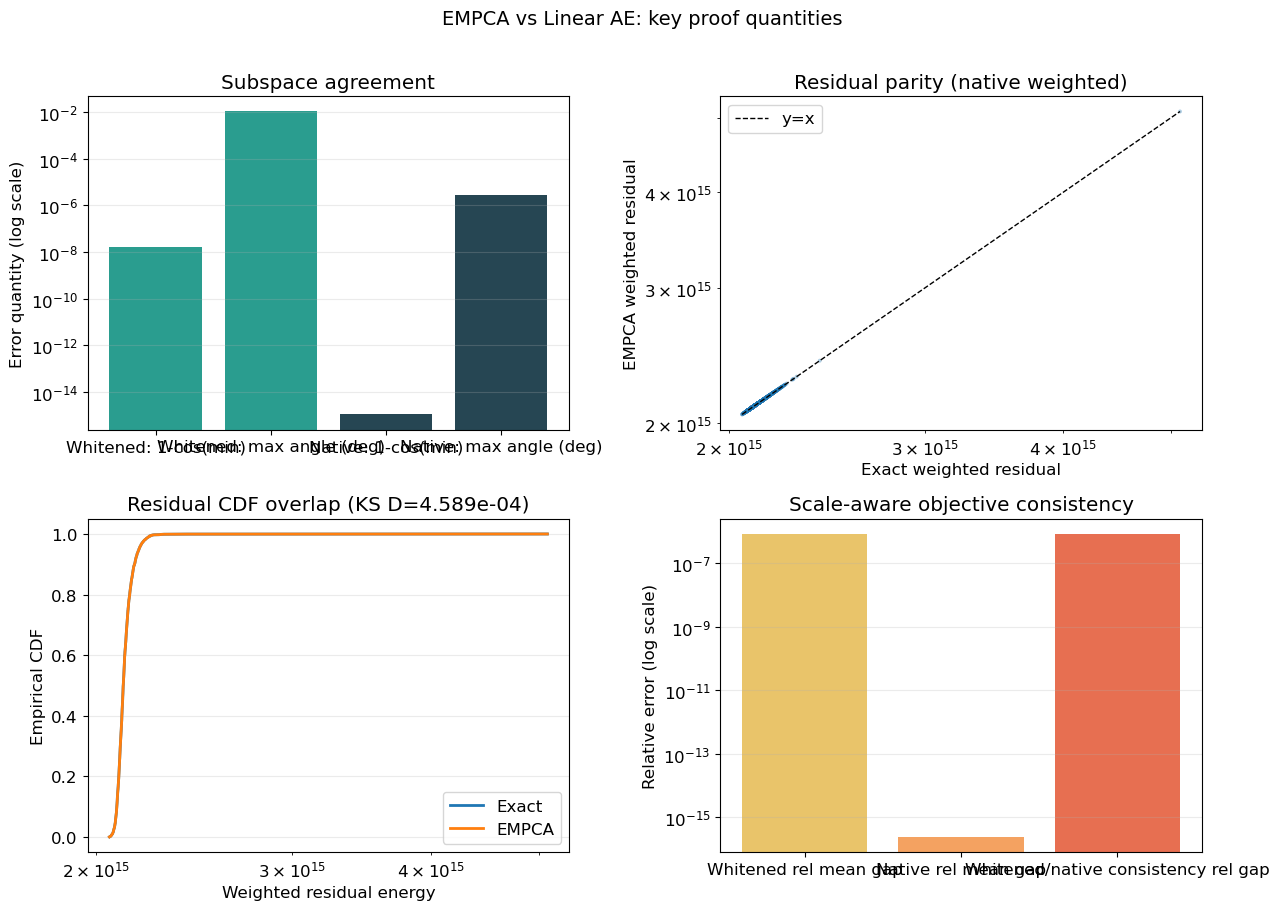

In [36]:
# Proof-only visualization of key quantities
eps = 1e-30

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# (A) Subspace agreement as error quantities (smaller is better)
subspace_names = [
    "Whitened: 1-cos(min)",
    "Whitened: max angle (deg)",
    "Native: 1-cos(min)",
    "Native: max angle (deg)",
]
subspace_vals = [
    float(1.0 - np.min(cos_w)),
    float(np.max(ang_w_deg)),
    float(1.0 - np.min(cos_emp_exact_n)),
    float(np.max(ang_emp_exact_n_deg)),
]
axes[0, 0].bar(subspace_names, subspace_vals, color=["#2a9d8f", "#2a9d8f", "#264653", "#264653"])
axes[0, 0].set_yscale("log")
axes[0, 0].set_ylabel("Error quantity (log scale)")
axes[0, 0].set_title("Subspace agreement")
axes[0, 0].grid(axis="y", alpha=0.25)

# (B) Weighted residual parity scatter (native objective)
x = resid_exact_n
y = resid_emp_n
lo = min(np.min(x), np.min(y))
hi = max(np.max(x), np.max(y))
axes[0, 1].scatter(x, y, s=8, alpha=0.35, edgecolor="none")
axes[0, 1].plot([lo, hi], [lo, hi], "k--", lw=1, label="y=x")
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("Exact weighted residual")
axes[0, 1].set_ylabel("EMPCA weighted residual")
axes[0, 1].set_title("Residual parity (native weighted)")
axes[0, 1].grid(alpha=0.25)
axes[0, 1].legend(loc="best")

# (C) Residual distribution agreement (CDF + KS)
xs = np.sort(resid_exact_n)
ys = np.sort(resid_emp_n)
cdf_x = np.arange(1, len(xs) + 1) / len(xs)
cdf_y = np.arange(1, len(ys) + 1) / len(ys)
axes[1, 0].plot(xs, cdf_x, lw=2, label="Exact")
axes[1, 0].plot(ys, cdf_y, lw=2, label="EMPCA")
axes[1, 0].set_xscale("log")
axes[1, 0].set_xlabel("Weighted residual energy")
axes[1, 0].set_ylabel("Empirical CDF")
axes[1, 0].set_title(f"Residual CDF overlap (KS D={ks_emp_exact_n.statistic:.3e})")
axes[1, 0].grid(alpha=0.25)
axes[1, 0].legend(loc="best")

# (D) Relative objective gaps (scale-aware; should be tiny)
gap_names = [
    "Whitened rel mean gap",
    "Native rel mean gap",
    "Whitened/native consistency rel gap",
]
gap_vals = [
    float(abs(rel_mean_diff_w)),
    float(abs(rel_emp_exact_n)),
    float(cons_rel),
]
axes[1, 1].bar(gap_names, gap_vals, color=["#e9c46a", "#f4a261", "#e76f51"])
axes[1, 1].set_yscale("log")
axes[1, 1].set_ylabel("Relative error (log scale)")
axes[1, 1].set_title("Scale-aware objective consistency")
axes[1, 1].grid(axis="y", alpha=0.25)

fig.suptitle("EMPCA vs Linear AE: key proof quantities", y=1.01, fontsize=14)
fig.tight_layout()


## Equivalence Decision Dashboard (Thresholded)

This is the final decision layer for equivalence:

- Each metric is converted to an error quantity.
- We divide by a tolerance.
- `ratio <= 1` means pass.


Equivalence scorecard (error metric / tolerance):
- whitened_subspace_cosine_gap               =  1.681694e-08 | tol= 1.00e-06 | ratio= 1.682e-02 | PASS
- whitened_max_principal_angle_deg           =  1.050778e-02 | tol= 1.00e-02 | ratio= 1.051e+00 | FAIL
- whitened_rel_mean_residual_diff            =  8.192430e-07 | tol= 1.00e-06 | ratio= 8.192e-01 | PASS
- whitened_residual_ks_D                     =  1.376778e-03 | tol= 1.00e-02 | ratio= 1.377e-01 | PASS
- native_subspace_cosine_gap                 =  1.110223e-15 | tol= 1.00e-06 | ratio= 1.110e-09 | PASS
- native_max_principal_angle_deg             =  2.699869e-06 | tol= 1.00e-02 | ratio= 2.700e-04 | PASS
- native_rel_mean_residual_diff              =  2.356162e-16 | tol= 1.00e-06 | ratio= 2.356e-10 | PASS
- native_residual_ks_D                       =  4.589261e-04 | tol= 1.00e-02 | ratio= 4.589e-02 | PASS
- native_log_residual_slope_error            =  8.881784e-16 | tol= 1.00e-02 | ratio= 8.882e-14 | PASS
- native_log_residual_i

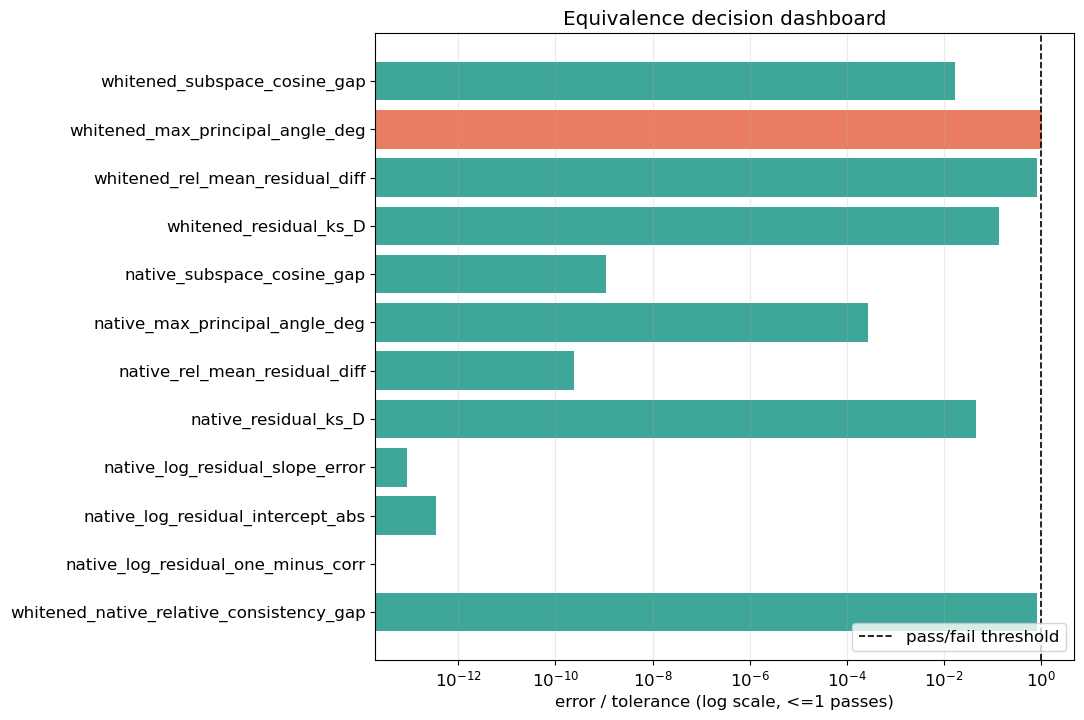

In [37]:
# Quantitative equivalence scorecard (key proof quantities only)
eps = 1e-30

# Log-residual parity metrics (native weighted, EMPCA vs exact)
logx = np.log10(np.maximum(resid_exact_n, eps))
logy = np.log10(np.maximum(resid_emp_n, eps))
slope_log, intercept_log = np.polyfit(logx, logy, 1)
corr_log = np.corrcoef(logx, logy)[0, 1]

proof_metrics = {
    "whitened_subspace_cosine_gap": float(1.0 - np.min(cos_w)),
    "whitened_max_principal_angle_deg": float(np.max(ang_w_deg)),
    "whitened_rel_mean_residual_diff": float(abs(rel_mean_diff_w)),
    "whitened_residual_ks_D": float(ks_w.statistic),
    "native_subspace_cosine_gap": float(1.0 - np.min(cos_emp_exact_n)),
    "native_max_principal_angle_deg": float(np.max(ang_emp_exact_n_deg)),
    "native_rel_mean_residual_diff": float(abs(rel_emp_exact_n)),
    "native_residual_ks_D": float(ks_emp_exact_n.statistic),
    "native_log_residual_slope_error": float(abs(slope_log - 1.0)),
    "native_log_residual_intercept_abs": float(abs(intercept_log)),
    "native_log_residual_one_minus_corr": float(1.0 - corr_log),
    "whitened_native_relative_consistency_gap": float(cons_rel),
}

proof_thresholds = {
    "whitened_subspace_cosine_gap": 1e-6,
    "whitened_max_principal_angle_deg": 1e-2,
    "whitened_rel_mean_residual_diff": 1e-6,
    "whitened_residual_ks_D": 1e-2,
    "native_subspace_cosine_gap": 1e-6,
    "native_max_principal_angle_deg": 1e-2,
    "native_rel_mean_residual_diff": 1e-6,
    "native_residual_ks_D": 1e-2,
    "native_log_residual_slope_error": 1e-2,
    "native_log_residual_intercept_abs": 5e-2,
    "native_log_residual_one_minus_corr": 1e-4,
    "whitened_native_relative_consistency_gap": 1e-6,
}

proof_pass = {}
print("Equivalence scorecard (error metric / tolerance):")
for k, v in proof_metrics.items():
    tol = proof_thresholds[k]
    ratio = v / (tol + eps)
    ok = ratio <= 1.0
    proof_pass[k] = bool(ok)
    tag = "PASS" if ok else "FAIL"
    print(f"- {k:42s} = {v: .6e} | tol={tol: .2e} | ratio={ratio: .3e} | {tag}")

print(f"Overall pass: {all(proof_pass.values())}")

# Ratio-to-threshold dashboard (<=1 is pass)
names = list(proof_metrics.keys())
vals = np.array([proof_metrics[n] for n in names], dtype=float)
tols = np.array([proof_thresholds[n] for n in names], dtype=float)
ratios = vals / (tols + eps)
colors = np.where(ratios <= 1.0, "#2a9d8f", "#e76f51")
y = np.arange(len(names))

fig, ax = plt.subplots(1, 1, figsize=(11, 0.48 * len(names) + 1.6))
ax.barh(y, ratios, color=colors, alpha=0.9)
ax.axvline(1.0, color="black", ls="--", lw=1.2, label="pass/fail threshold")
ax.set_xscale("log")
ax.set_yticks(y)
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_xlabel("error / tolerance (log scale, <=1 passes)")
ax.set_title("Equivalence decision dashboard")
ax.grid(alpha=0.25, axis="x")
ax.legend(loc="lower right")
fig.tight_layout()


In [38]:
# Save concise summary
summary = {
    "data": {
        "n_total": int(X_all.shape[0]),
        "n_train": int(X_train_t.shape[0]),
        "n_test": int(X_test_t.shape[0]),
        "trace_len": int(X_all.shape[1]),
        "rfft_bins": int(X_train_f.shape[1]),
    },
    "model": {
        "k": int(K),
        "empca_n_iter_requested": int(N_ITER_EMPCA),
        "empca_patience": int(EMPCA_PATIENCE),
        "ae_epochs": int(AE_EPOCHS),
    },
    "section_A_whitened": {
        "principal_angle_cosines": [float(v) for v in cos_w],
        "principal_angles_deg": [float(v) for v in ang_w_deg],
        "residual_ks_statistic": float(ks_w.statistic),
        "residual_ks_pvalue": float(ks_w.pvalue),
        "mean_test_reconstruction_gap": float(recon_gap_w),
        "empca_test_resid_mean": float(np.mean(resid_emp_w)),
        "exact_ae_test_resid_mean": float(np.mean(resid_exact_w)),
        "relative_mean_residual_diff": float(rel_mean_diff_w),
    },
    "section_B_native_weighted": {
        "empca_vs_exact": {
            "principal_angle_cosines": [float(v) for v in cos_emp_exact_n],
            "principal_angles_deg": [float(v) for v in ang_emp_exact_n_deg],
            "residual_ks_statistic": float(ks_emp_exact_n.statistic),
            "residual_ks_pvalue": float(ks_emp_exact_n.pvalue),
            "empca_test_resid_mean": float(np.mean(resid_emp_n)),
            "exact_test_resid_mean": float(np.mean(resid_exact_n)),
            "relative_mean_residual_diff": float(rel_emp_exact_n),
        },
        "iterative_ae_vs_exact": {
            "principal_angle_cosines": [float(v) for v in cos_iter_exact_n],
            "principal_angles_deg": [float(v) for v in ang_iter_exact_n_deg],
            "residual_ks_statistic": float(ks_iter_exact_n.statistic),
            "residual_ks_pvalue": float(ks_iter_exact_n.pvalue),
            "iterative_test_resid_mean": float(np.mean(resid_iter_n)),
            "exact_test_resid_mean": float(np.mean(resid_exact_n)),
            "relative_mean_residual_diff": float(rel_iter_exact_n),
        },
    },
}


summary["proof_scorecard"] = {
    "thresholds": {k: float(v) for k, v in proof_thresholds.items()},
    "metrics": {k: float(v) for k, v in proof_metrics.items()},
    "pass": {k: bool(v) for k, v in proof_pass.items()},
    "overall_pass": bool(all(proof_pass.values())),
}

from pathlib import Path
out_path = Path("empca_ae_whiten_vs_weighted_equivalence_summary.json")
out_path.write_text(json.dumps(summary, indent=2))
print(f"Saved summary to {out_path.resolve()}")


Saved summary to /home/dwong/DELight_mtr/PCA_dev/wk4/equivalence/empca_ae_whiten_vs_weighted_equivalence_summary.json


## Interpretation guide

Treat equivalence as established when all thresholded key metrics pass:

- Subspace agreement: tiny cosine-gap and tiny principal-angle error.
- Objective agreement: tiny relative residual mismatch and low KS D.
- Residual parity geometry: log-parity slope near 1, intercept near 0, correlation near 1.
- Representation consistency: tiny whitened/native relative consistency gap.

In this notebook, the final proof decision is the scorecard: `overall_pass == True`.
